# 대한민국 인구 조사

In [69]:
import requests 
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import seaborn as sns

mpl.rc('font', family = 'Malgun Gothic')
mpl.rc('axes', unicode_minus = False) # unicode의 음수부호 설정 false

## 1. Wikipedia에서 데이터 가져오기

In [ ]:
url = 'https://ko.wikipedia.org/wiki/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD%EC%9D%98_%EC%9D%B8%EA%B5%AC'
response = requests.get(url)
html = response.text 
soup = BeautifulSoup(html, 'html.parser')
# soup

* class 명이 `wikitable sortable jquery-tablesorter`인 줄 알았으나 jquery-tablesorter는 클래스명이 아닌것으로 확인됨.

In [46]:
tables = soup.find('table', class_='wikitable sortable')
tables

<table class="wikitable sortable">
<tbody><tr>
<th>연도 (년)
</th>
<th>추계인구(명)
</th>
<th>출생자수(명)
</th>
<th>사망자수(명)
</th>
<th>자연증가수(명)
</th>
<th>조출생률 (1000명당)
</th>
<th>조사망률 (1000명당)
</th>
<th>자연증가율 (1000명당)
</th>
<th>합계출산율
</th></tr>
<tr>
<td>1925
</td>
<td style="text-align:right;">12,997,611
</td>
<td style="text-align:right;">558,897
</td>
<td style="text-align:right;">359,042
</td>
<td style="text-align:right;">199,855
</td>
<td style="text-align:right;">43.0
</td>
<td style="text-align:right;">27.6
</td>
<td style="text-align:right;">15.4
</td>
<td style="text-align:right; color:blue">6.59
</td></tr>
<tr>
<td>1926
</td>
<td style="text-align:right;">13,052,741
</td>
<td style="text-align:right;">511,667
</td>
<td style="text-align:right;">337,948
</td>
<td style="text-align:right;">173,719
</td>
<td style="text-align:right;">39.2
</td>
<td style="text-align:right;">25.9
</td>
<td style="text-align:right;">13.3
</td>
<td style="text-align:right; color:blue">
</td></tr>
<tr>
<td>1927
<

In [65]:
cols = mytbl.select('tbody > tr > th')
columns = [col.text.strip('\n') for col in cols]
columns

['연도 (년)',
 '추계인구(명)',
 '출생자수(명)',
 '사망자수(명)',
 '자연증가수(명)',
 '조출생률 (1000명당)',
 '조사망률 (1000명당)',
 '자연증가율 (1000명당)',
 '합계출산율']

In [156]:
rows = mytbl.select('tbody > tr')
del rows[0]

lst = []
for row in rows:
    rs = row.select('td')
    
    temp = []
    for r in rs:
        cell = r.text.strip('\n')
        temp.append(re.sub('[^0-9.\-]','',cell))
        
    lst.append(temp) 

lst[2]

['1927', '13037169', '534524', '353818', '180706', '41.0', '27.1', '13.9', '']

## 2. 데이터 프레임 만들기(dtype 주의)

In [251]:
mydf = pd.DataFrame(lst, columns=columns)
mydf = mydf.set_index('연도 (년)')
mydf.index = list(range(1925, 2022))

* 데이터 분리하기 (int인 변수, float인 변수)

> 헤맸던 부분 <br>
astype으로 int, float로 데이터타입을 바꿀 때 공백이 있으면 오류가 난다. <br>
공백으로 표시된 부분을 'NaN'으로 바꿔서 진행했고, `errors='ignore'`을 통해 공백으로 인한 에러를 무시했다. 

In [298]:
df1 = mydf[mydf.columns[:4]]
df2 = mydf[mydf.columns[4:]]

df1 = df1.astype('int', errors='ignore')
df2 = df2.replace('', np.NaN)
df2 = df2.astype('f', errors='ignore')
df2.dtypes

조출생률 (1000명당)     float32
조사망률 (1000명당)     float32
자연증가율 (1000명당)    float32
합계출산율             float32
dtype: object

* 연도의 dtype을 날짜로 바꾸고 싶다. (나중에 시계열 자료를 위해 알아두고 싶었다)

> 헤맸던 부분 <br>
`datetime.strftime`으로 해결해보려고 했지만, Series는 적용이 되지 않는다고 한다. <br>
pandas 내장함수로 바꿀 수 있는 방법을 찾았으나 연도만 있는 경우 자동으로 1월 1일로 인식함을 알게 되었다. <br>
지금 하는 시각화에는 맞지 않는 것 같아 넘어간다.

In [119]:
# mydf['연도 (년)'] = pd.to_datetime(mydf['연도 (년)'], format='%Y')

0    1925-01-01
1    1926-01-01
2    1927-01-01
3    1928-01-01
4    1929-01-01
        ...    
92   2017-01-01
93   2018-01-01
94   2019-01-01
95   2020-01-01
96   2021-01-01
Name: 연도 (년), Length: 97, dtype: datetime64[ns]

## 3. 시각화하기

In [253]:
# 전체 설정
mpl.rcParams.update({'font.size': 15})


### 1) 무작정 따라하기 

#### 1925-2019 한국의 출생아 수, 사망자 수 

> 헤맸던 부분 1<br>
맨 처음 배웠던 대로 `plt.figure(figsize=())`를 통해 사이즈를 조절하고자 했지만, 잘 되지 않았다.<br>
pandas의 데이터프레임인 경우 `plt.plot()`이 아닌`df.plot()`로 그렸기 때문에 `df`에 대해 옵션을 지정해주어야 하는 것 같다. 

> 헤맸던 부분 2<br>
x축과 y축 단위가 수학적으로 표현지 않게 하기 위한 시도를 하였으나 `plt.ticklabel_format(useOffset=False)`는 잘 실행되지 않았다.<br>
`ticklabel_format(style='plain', axis='y')`과 어떤 차이가 있는지는 아직 잘 모르겠다. 

* 하고 싶은 것 
    - ytick label을 만명단위로 고치기 
    - legend 일렬로 정리하기
    - 사망자가 꾸준히 늘어나는 것은 어떤 의미일지 유추해보기 
    - 반대로 출생자 수가 급감한 구간은 어떤 일이 있었는지 유추해보기 

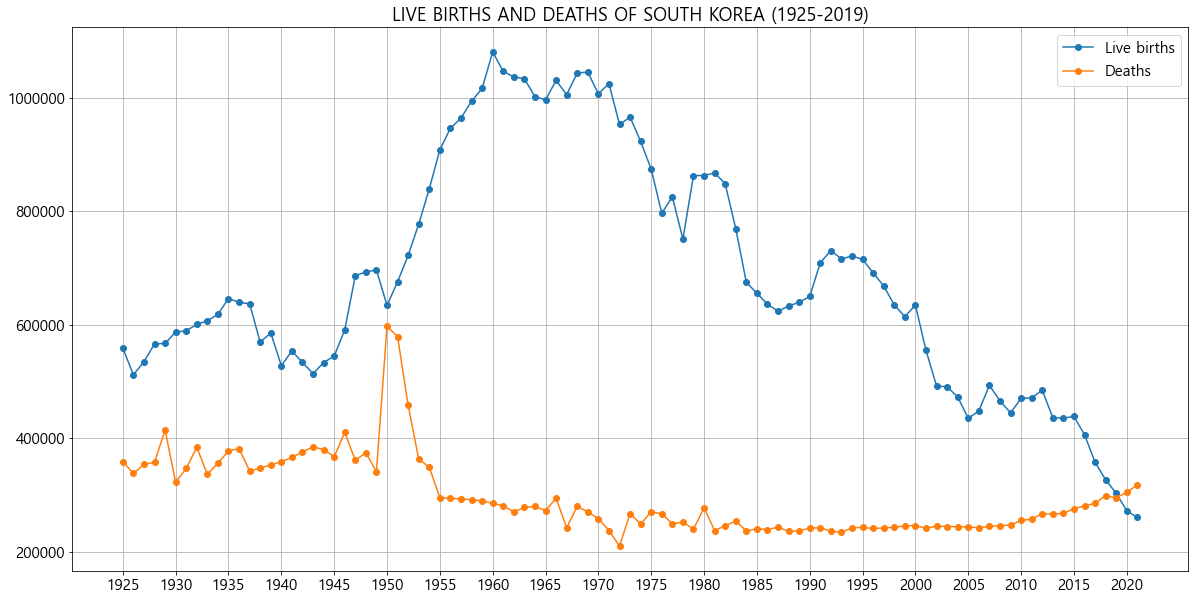

In [260]:
df = df1[['출생자수(명)', '사망자수(명)']]
df.plot(figsize=(20, 10), marker='o')
plt.title('LIVE BIRTHS AND DEATHS OF SOUTH KOREA (1925-2019)')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(list(range(1925,2022,5)))
plt.grid(True)
plt.legend(['Live births', 'Deaths'])
plt.show()


#### 1925-2019 한국의 조출생률, 조사망률 

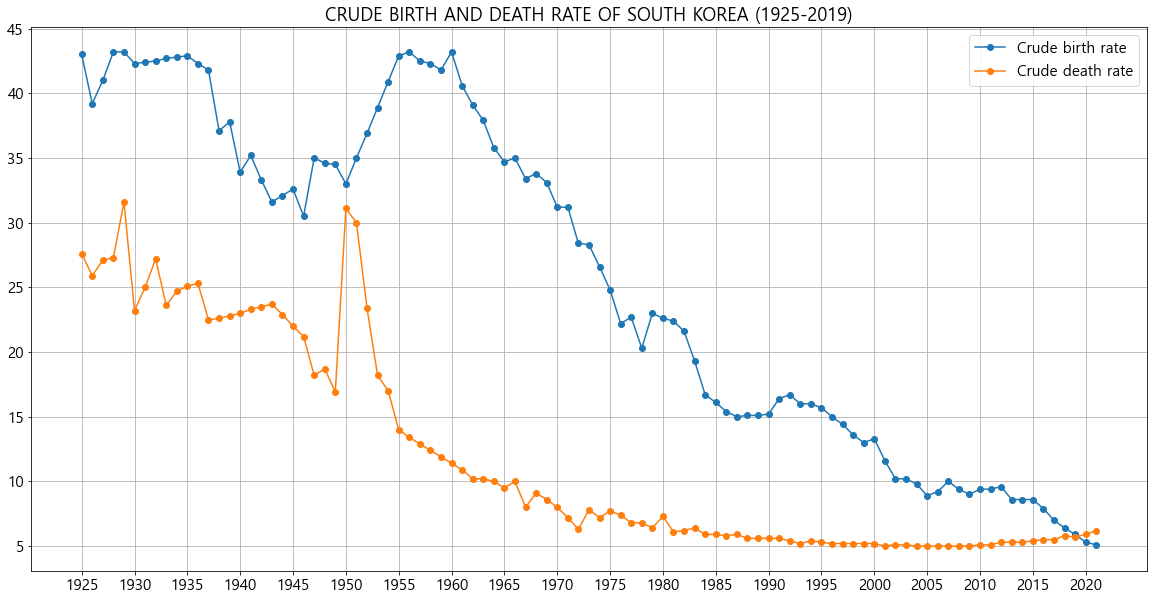

In [300]:
df = df2[['조출생률 (1000명당)', '조사망률 (1000명당)']]
df.plot(figsize=(20, 10), marker='o')
plt.title('CRUDE BIRTH AND DEATH RATE OF SOUTH KOREA (1925-2019)')
plt.xticks(list(range(1925,2022,5)))
plt.grid(True)
plt.legend(['Crude birth rate', 'Crude death rate'])
plt.show()

### 2) 내맘대로 그리기

In [125]:
mydf.columns

Index(['추계인구(명)', '출생자수(명)', '사망자수(명)', '자연증가수(명)', '조출생률 (1000명당)',
       '조사망률 (1000명당)', '자연증가율 (1000명당)', '합계출산율'],
      dtype='object')

> 헤맸던 부분 <br>
전체 총 인구수와 출생, 사망, 자연증가 등의 상황을 한번에 파악하는 그래프를 만들고 싶었다. <br>
생각보다 짬봉해야하는 기능들이 많아 제일 많은 시간이 걸렸다. 

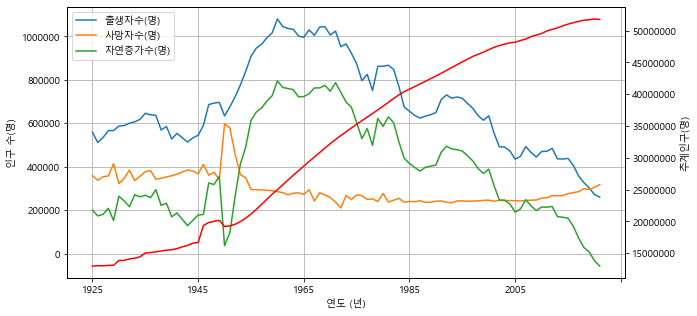

In [207]:
total = df1['추계인구(명)']
split = df1[['출생자수(명)','사망자수(명)','자연증가수(명)']]

fig, axes1 = plt.subplots(figsize = (10, 5))

split.plot(ax=axes1)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('인구 수(명)')
plt.legend(loc=2)
plt.grid(True)

axes2 = axes1.twinx()
total.plot(secondary_y=True, ax=axes2, c='red')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('추계인구(명)')

plt.show()

In [ ]:
trend_df_hours = pd.Series(np.random.rand(10))
trend_df_qty = pd.Series(np.random.rand(10))

fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()

trend_df_hours.plot(kind='bar', stacked=True, ax=ax0)
trend_df_qty.plot(kind='line', secondary_y=True, ax=ax1)
plt.show()
plt.close()

# 시각화 참고

<AxesSubplot:xlabel='연도', ylabel='추계인구'>

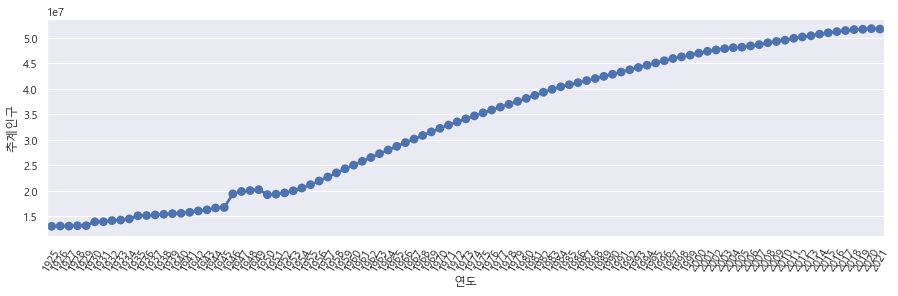

In [ ]:
## 그래프 사이즈 조정
plt.figure(figsize=(15, 4))  # 표의 크기 및 비율 조정
plt.xticks(rotation=60)   # 글씨를 60도씩 돌려서 보일 수 있도록
sns.pointplot(data=df, x="연도", y="추계인구")


<AxesSubplot:xlabel='연도', ylabel='출생자수'>

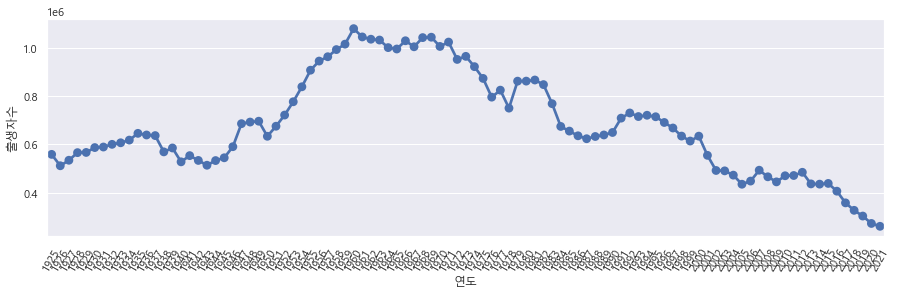

In [ ]:
## Point Plot으로 출생자수 그리기
plt.figure(figsize=(15, 4))  # 표의 크기 및 비율 조정
plt.xticks(rotation=60)   # 글씨를 60도씩 돌려서 보일 수 있도록
sns.pointplot(data=df, x="연도", y="출생자수")


In [ ]:
### 위 표의 왼쪽 위에 "1e6" 이라고 쓰인 부분은... 10의 6승 즉 1,000,000(백반) 단위 표시임


<AxesSubplot:xlabel='연도', ylabel='출생자수'>

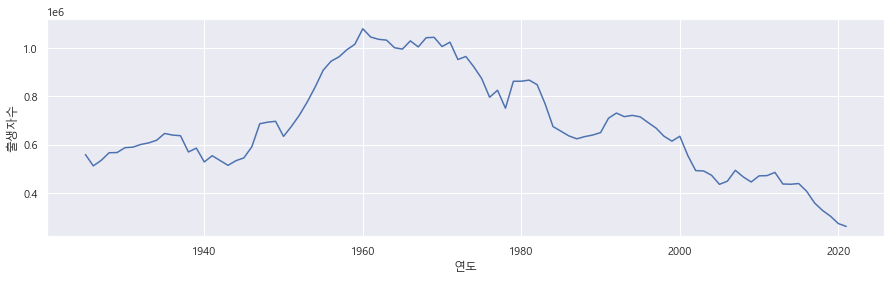

In [ ]:
## Line Plot으로 출생자수 그리기
plt.figure(figsize=(15, 4))  # 표의 크기 및 비율 조정
# plt.xticks(rotation=60)   # 글씨를 60도씩 돌려서 보일 수 있도록
sns.lineplot(data=df, x="연도", y="출생자수")


<AxesSubplot:xlabel='연도', ylabel='사망자수'>

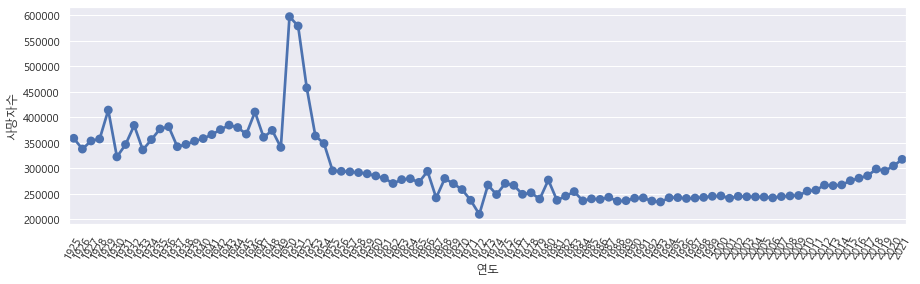

In [ ]:
## Point Plot으로 사망자수 그리기

plt.figure(figsize=(15, 4))  # 표의 크기 및 비율 조정
plt.xticks(rotation=60)   # 글씨를 60도씩 돌려서 보일 수 있도록
sns.pointplot(data=df, x="연도", y="사망자수")


<AxesSubplot:xlabel='연도', ylabel='사망자수'>

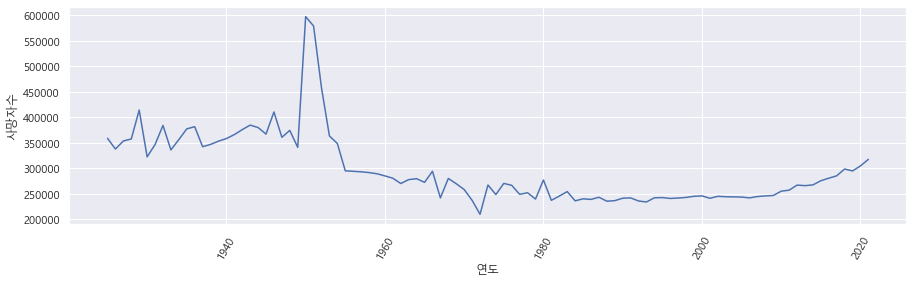

In [ ]:
## Line Plot으로 사망자수 그리기

plt.figure(figsize=(15, 4))  # 표의 크기 및 비율 조정
plt.xticks(rotation=60)   # 글씨를 60도씩 돌려서 보일 수 있도록
sns.lineplot(data=df, x="연도", y="사망자수")


<AxesSubplot:xlabel='연도', ylabel='사망자수'>

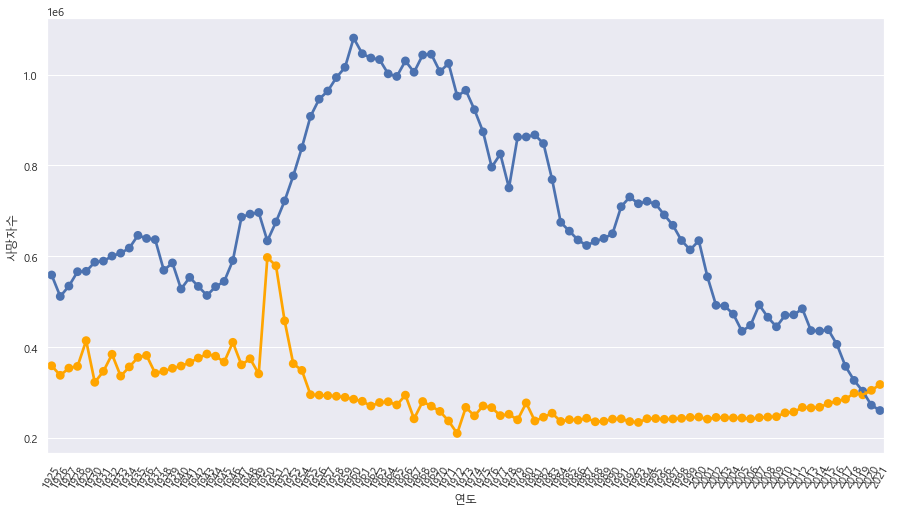

In [ ]:
# 출생자수와 사망자 수를 point plot으로...
plt.figure(figsize=(15, 8))  # 비율을 세로로 키움
plt.xticks(rotation=60)   # 글씨를 60도씩 돌려서 보일 수 있도록
sns.pointplot(data=df, x="연도", y="출생자수")
sns.pointplot(data=df, x="연도", y="사망자수", color="orange")


In [ ]:
###########################################
# pandas로 그려보기
###########################################
df.columns


Index(['연도', '추계인구', '출생자수', '사망자수', '자연증가', '조출생률', '조사망률', '자연증가율'], dtype='object')

In [ ]:
# 위의 데이터 중에서 출생자수와 사망자수만 필요함
df[['연도', '출생자수', '사망자수']]


,연도,출생자수,사망자수
0,1925,558897,359042
1,1926,511667,337948
2,1927,534524,353818
3,1928,566142,357701
4,1929,566969,414366
...,...,...,...
92,2017,357771,285534
93,2018,326822,298820
94,2019,303054,295132
95,2020,272337,304948


<AxesSubplot:>

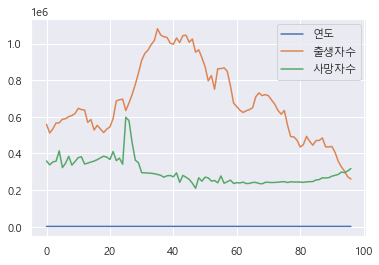

In [ ]:
# 판다스 플롯 (간단히 그려볼 수 있음)
df[['연도', '출생자수', '사망자수']].plot()


In [ ]:
# 연도를 x축에 표시하고 싶으면... 연도를 Index로 만들어 주어야 함
# 작업을 위해 df를 복사해서 하나 만듬
df_pop = df[['연도', '출생자수', '사망자수']]
df_pop = df_pop.set_index("연도")
df_pop


,출생자수,사망자수
연도,,
1925,558897,359042
1926,511667,337948
1927,534524,353818
1928,566142,357701
1929,566969,414366
...,...,...
2017,357771,285534
2018,326822,298820
2019,303054,295132


<AxesSubplot:xlabel='연도'>

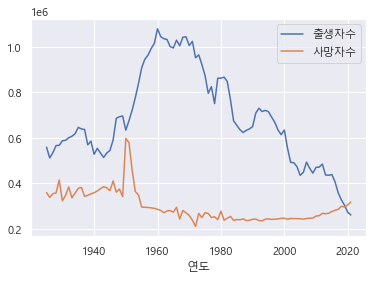

In [ ]:
df_pop.plot()


<AxesSubplot:xlabel='연도'>

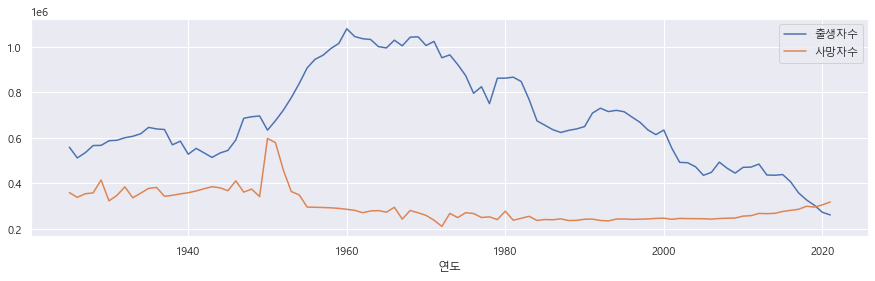

In [ ]:
df_pop.plot(figsize=(15, 4))  # 크기 조정


<AxesSubplot:xlabel='연도'>

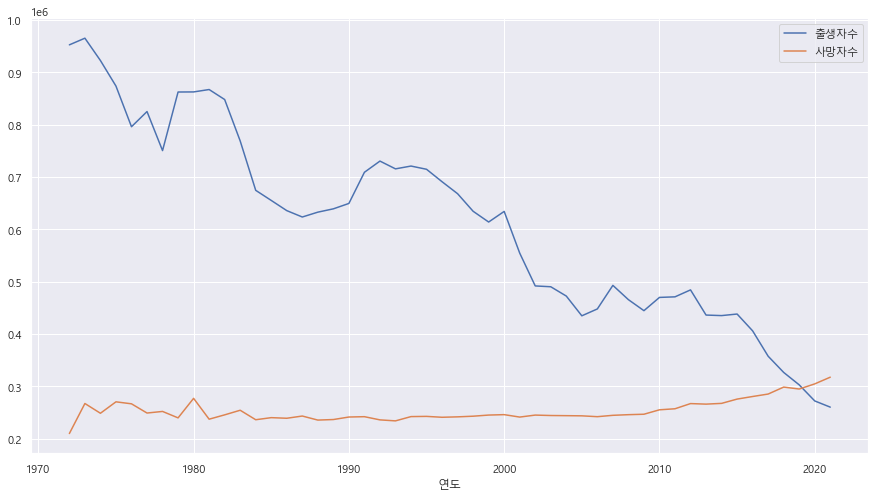

In [ ]:
### 최근 50년만 그려보기
### slicing 이용
df_pop[-50:].plot(figsize=(15, 8))


<AxesSubplot:xlabel='연도', ylabel='사망자수'>

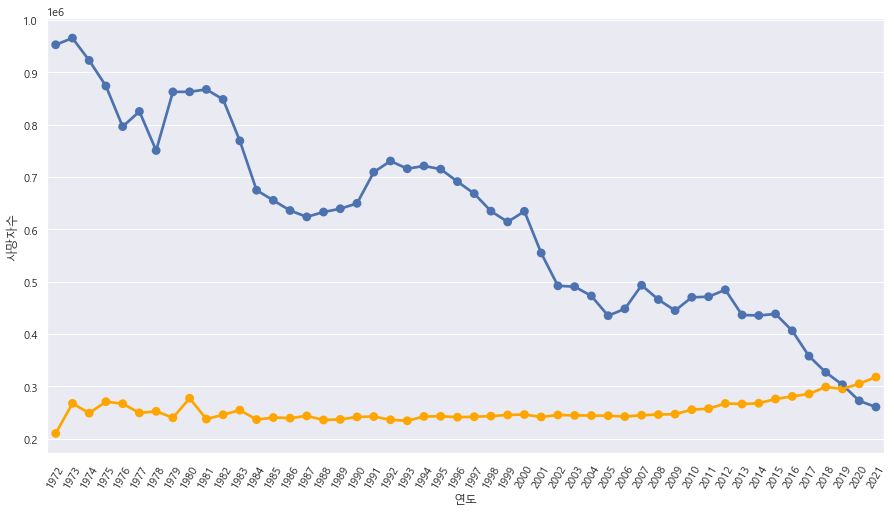

In [ ]:
### seaborn으로 최근 50년만 그려보기
plt.figure(figsize=(15, 8)) 
plt.xticks(rotation=60)  
sns.pointplot(data=df[-50:], x="연도", y="출생자수")
sns.pointplot(data=df[-50:], x="연도", y="사망자수", color="orange")


<AxesSubplot:xlabel='연도', ylabel='추계인구'>

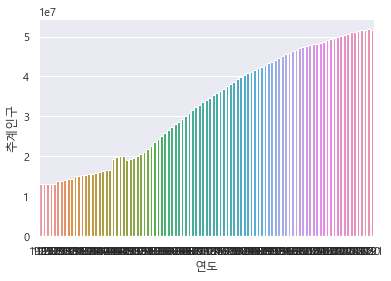

In [ ]:
## 추계인구 데이터 bar plot (막대그래프)
sns.barplot(data=df, x="연도", y="추계인구")


<AxesSubplot:xlabel='연도', ylabel='추계인구'>

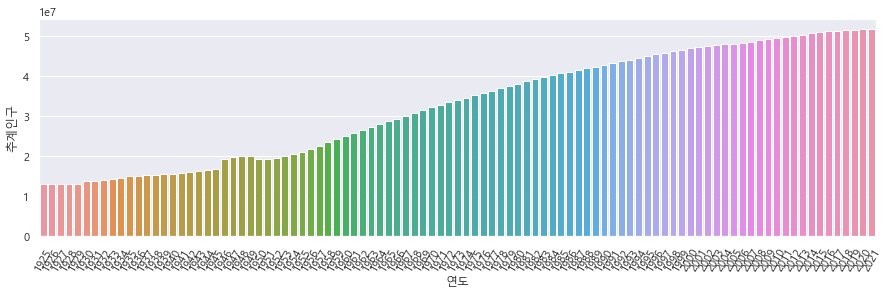

In [ ]:
# 크기 조정
plt.figure(figsize=(15, 4))  # 비율 조정
plt.xticks(rotation=60) # 글씨 60도 회전
sns.barplot(data=df, x="연도", y="추계인구")


<AxesSubplot:xlabel='연도', ylabel='추계인구'>

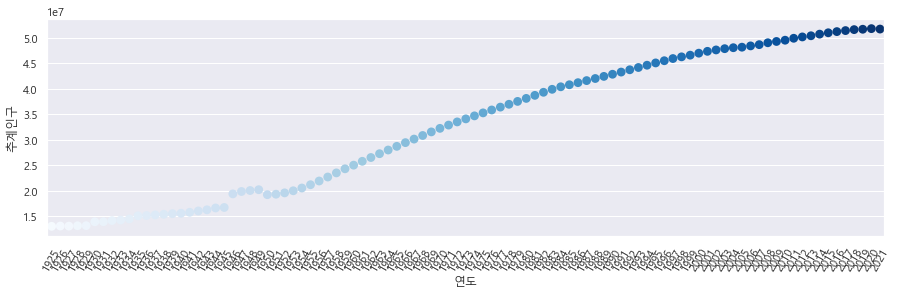

In [ ]:
# point plot으로 (블루 그라디에이션)
plt.figure(figsize=(15, 4))  # 비율 조정
plt.xticks(rotation=60) # 글씨 60도 회전
sns.pointplot(data=df, x="연도", y="추계인구", palette="Blues") # 파란색들의 명암 조절로...!


<AxesSubplot:xlabel='연도', ylabel='추계인구'>

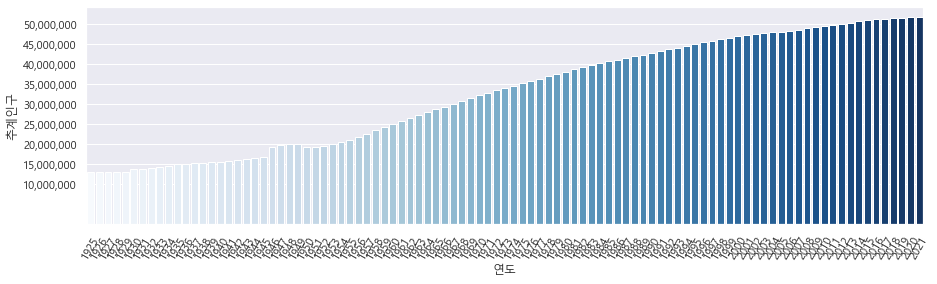

In [ ]:
# 여러가지 색상이 아니라 한가지 색으로만 Gradiation 처리
plt.figure(figsize=(15, 4))  # 비율 조정
# plt.xticks(rotation=60) # 글씨 60도 회전
plt.xticks(list(range(1925, 2022, 5)), list(map(str, range(1925, 2022, 5))),
          rotation=60)
plt.yticks([1.0e7, 1.5e7, 2.0e7, 2.5e7, 3.0e7, 3.5e7, 4.0e7, 4.5e7, 5.0e7], 
           ['10,000,000', '15,000,000','20,000,000', '25,000,000',
           '30,000,000', '35,000,000','40,000,000', '45,000,000',
           '50,000,000'])
sns.barplot(data=df, x="연도", y="추계인구", palette="Blues") # 파란색들의 명암 조절로...!


<AxesSubplot:xlabel='연도', ylabel='추계인구'>

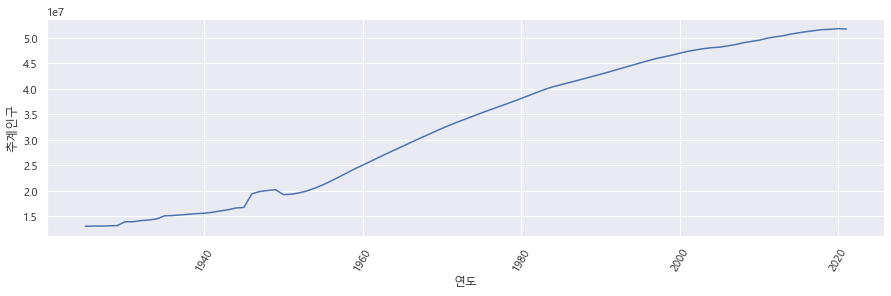

In [ ]:
# line plot으로 
plt.figure(figsize=(15, 4))  # 비율 조정
plt.xticks(rotation=60) # 글씨 60도 회전
sns.lineplot(data=df, x="연도", y="추계인구") #  palette="Blues") # lineplot는 palette  기능 없음
